In [7]:
import pandas as pd
intervals= [
    {'lower': 'q_1', 'upper': 'q_99', 'alpha': 0.02},    # 98% PI
    {'lower': 'q_2', 'upper': 'q_97', 'alpha': 0.05}, # 95% PI
    {'lower': 'q_5', 'upper': 'q_95', 'alpha': 0.1},     # 90% PI
    {'lower': 'q_10', 'upper': 'q_90', 'alpha': 0.2},    # 80% PI
    {'lower': 'q_15', 'upper': 'q_85', 'alpha': 0.3},    # 70% PI
    {'lower': 'q_20', 'upper': 'q_80', 'alpha': 0.4},    # 60% PI
    {'lower': 'q_25', 'upper': 'q_75', 'alpha': 0.5},    # 50% PI
    {'lower': 'q_30', 'upper': 'q_70', 'alpha': 0.6},    # 40% PI
    {'lower': 'q_35', 'upper': 'q_65', 'alpha': 0.7},    # 30% PI
    {'lower': 'q_40', 'upper': 'q_60', 'alpha': 0.8},    # 20% PI
    {'lower': 'q_45', 'upper': 'q_55', 'alpha': 0.9}     # 10% PI
]
def create_ensemble_model(models, intervals, input_path_template="../res/{model}/{model}_base_week_holi_pf_42test.csv",
                         output_path="../res/ensemble_model_with_intervals.csv"):
    # 提取分位数列名
    quantile_columns = list(set([interval['lower'] for interval in intervals] +
                              [interval['upper'] for interval in intervals]))
    required_columns = ['point', 'true', 'date', 'week_ahead'] + quantile_columns

    # 读取并过滤每个模型的数据
    dfs = []
    for model in models:
        file_path = input_path_template.format(model=model)
        df = pd.read_csv(file_path)  # 如果文件非 CSV，需调整
        if 'mode' in df.columns:
            df = df[(df['mode'] == 'train')|(df['mode']=='train_seed42')][required_columns]
        else:
            df = df[required_columns]
        df['model'] = model  # 添加模型名称用于追踪
        dfs.append(df)

    # 合并所有数据框
    combined_df = pd.concat(dfs, ignore_index=True)

    # 按 date 和 week_ahead 对齐预测
    pivot_df = combined_df.pivot_table(
        index=['date', 'week_ahead', 'true'],
        columns='model',
        values=['point'] + quantile_columns,
        aggfunc='mean'
    ).reset_index()

    # 展平多级列名
    pivot_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in pivot_df.columns]

    # 计算集成点预测
    pivot_df['point'] = pivot_df[[f'point_{model}' for model in models]].mean(axis=1, skipna=True)

    # 计算集成预测区间，保持原始分位数列名
    for interval in intervals:
        lower_col = interval['lower']
        upper_col = interval['upper']
        pivot_df[lower_col] = pivot_df[[f'{lower_col}_{model}' for model in models]].mean(axis=1, skipna=True)
        pivot_df[upper_col] = pivot_df[[f'{upper_col}_{model}' for model in models]].mean(axis=1, skipna=True)

    # 选择输出列
    output_columns = ['date', 'week_ahead', 'true', 'point'] + \
                     [interval['lower'] for interval in intervals] + \
                     [interval['upper'] for interval in intervals]
    ensemble_df = pivot_df[output_columns]

    # 保存集成结果
    ensemble_df.to_csv(output_path, index=False)

    # 检查缺失预测
    missing_data = pivot_df[[f'point_{model}' for model in models] +
                           [f'{q}_{model}' for q in quantile_columns for model in models]].isna().any(axis=1)
    if missing_data.any():
        print("警告：某些模型在特定 date/week_ahead 组合下缺少预测数据。")
        print(pivot_df[missing_data][['date', 'week_ahead']])

    return ensemble_df

ensemble_df = create_ensemble_model(['itransformer','gru','tcn','Nbeats'],intervals)
ensemble_df3 = create_ensemble_model(['itransformer','gru','tcn','Nbeats'],intervals, input_path_template="../res/{model}/{model}_base_week_42test.csv",
                         output_path="../res/ensemble_model_with_intervals_base_week.csv")
ensemble_df4 = create_ensemble_model(['itransformer','gru','tcn','Nbeats'],intervals, input_path_template="../res/{model}/{model}_base_42test.csv",
                         output_path="../res/ensemble_model_with_intervals_base.csv")


In [8]:
def create_avg_model(models, intervals,
                         output_path="../res/ensemble_model.csv"):
    # 提取分位数列名
    quantile_columns = list(set([interval['lower'] for interval in intervals] +
                              [interval['upper'] for interval in intervals]))
    required_columns = ['point', 'true', 'date', 'week_ahead'] + quantile_columns

    # 读取并过滤每个模型的数据
    dfs = []
    for model in models:
        file_path = model
        df = pd.read_csv(file_path)  # 如果文件非 CSV，需调整
        if 'mode' in df.columns:
            df = df[df['mode'] == 'train'][required_columns]
        else:
            df = df[required_columns]
        df['model'] = model  # 添加模型名称用于追踪
        dfs.append(df)

    # 合并所有数据框
    combined_df = pd.concat(dfs, ignore_index=True)

    # 按 date 和 week_ahead 对齐预测
    pivot_df = combined_df.pivot_table(
        index=['date', 'week_ahead', 'true'],
        columns='model',
        values=['point'] + quantile_columns,
        aggfunc='mean'
    ).reset_index()

    # 展平多级列名
    pivot_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in pivot_df.columns]

    # 计算集成点预测
    pivot_df['point'] = pivot_df[[f'point_{model}' for model in models]].mean(axis=1, skipna=True)

    # 计算集成预测区间，保持原始分位数列名
    for interval in intervals:
        lower_col = interval['lower']
        upper_col = interval['upper']
        pivot_df[lower_col] = pivot_df[[f'{lower_col}_{model}' for model in models]].mean(axis=1, skipna=True)
        pivot_df[upper_col] = pivot_df[[f'{upper_col}_{model}' for model in models]].mean(axis=1, skipna=True)

    # 选择输出列
    output_columns = ['date', 'week_ahead', 'true', 'point'] + \
                     [interval['lower'] for interval in intervals] + \
                     [interval['upper'] for interval in intervals]
    ensemble_df = pivot_df[output_columns]

    # 保存集成结果
    ensemble_df.to_csv(output_path, index=False)

    # 检查缺失预测
    missing_data = pivot_df[[f'point_{model}' for model in models] +
                           [f'{q}_{model}' for q in quantile_columns for model in models]].isna().any(axis=1)
    if missing_data.any():
        print("警告：某些模型在特定 date/week_ahead 组合下缺少预测数据。")
        print(pivot_df[missing_data][['date', 'week_ahead']])

# models = ["../res/ensemble_model_with_intervals_no_ol.csv","../res/ensemble_model_with_intervals.csv"]
# create_avg_model(models, intervals,
#                          output_path="../res/ensemble_model.csv")

In [9]:
intervals= [
    {'lower': 'q_1', 'upper': 'q_99', 'alpha': 0.02},    # 98% PI
    {'lower': 'q_2', 'upper': 'q_97', 'alpha': 0.05}, # 95% PI
    {'lower': 'q_5', 'upper': 'q_95', 'alpha': 0.1},     # 90% PI
    {'lower': 'q_10', 'upper': 'q_90', 'alpha': 0.2},    # 80% PI
    {'lower': 'q_15', 'upper': 'q_85', 'alpha': 0.3},    # 70% PI
    {'lower': 'q_20', 'upper': 'q_80', 'alpha': 0.4},    # 60% PI
    {'lower': 'q_25', 'upper': 'q_75', 'alpha': 0.5},    # 50% PI
    {'lower': 'q_30', 'upper': 'q_70', 'alpha': 0.6},    # 40% PI
    {'lower': 'q_35', 'upper': 'q_65', 'alpha': 0.7},    # 30% PI
    {'lower': 'q_40', 'upper': 'q_60', 'alpha': 0.8},    # 20% PI
    {'lower': 'q_45', 'upper': 'q_55', 'alpha': 0.9}     # 10% PI
]
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # 避免分母为 0（如果 y_true + y_pred = 0，替换成很小的数）
    denominator = (np.abs(y_true) + np.abs(y_pred))
    denominator = np.where(denominator == 0, 1e-10, denominator)
    return np.mean(np.abs(y_pred - y_true) / denominator) * 100  # 百分比形式

def interval_score(y, lower, upper, alpha):
    width = upper - lower
    penalty_lower = (2 / alpha) * (lower - y) * (y < lower)
    penalty_upper = (2 / alpha) * (y - upper) * (y > upper)
    return width + penalty_lower + penalty_upper

def calculate_coverate(t,rate='95'):
    intervals = {
              "95":  {'lower': 'q_2', 'upper': 'q_97'},  # 95%
              "80":   {'lower': 'q_10', 'upper': 'q_90'},     # 80%
              "50":   {'lower': 'q_25', 'upper': 'q_75'},     # 50%
    }
    interval = intervals[rate]

    y = t['true']
    metrics = {}
    lower = t[interval['lower']] if interval['lower'] else -np.inf
    upper = t[interval['upper']] if interval['upper'] else np.inf
    correct = (y >= lower) & (y <= upper)
    coverate = np.mean(correct)
    return coverate

def calculate_wis(row):
    y = row['true']
    median = y
    K = len(intervals)  # 区间数量

    # 计算所有区间的 IS
    interval_scores = sum(
        0.5 * interval['alpha'] *interval_score(y, row[interval['lower']], row[interval['upper']], interval['alpha'])
        for interval in intervals
    )

    # 中位数误差
    median_penalty = 0.5 * abs(y - median)

    # WIS
    wis = (interval_scores + median_penalty) / (K + 0.5)
    return wis

def median_absolute_error(y_true, y_pred):
    absolute_errors = np.abs(y_true - y_pred)
    return np.median(absolute_errors)

def calculate_accuracy_with_tolerance(true_values, pred_values, tolerance=0.25):
    lower_bound = true_values * (1 - tolerance)
    upper_bound = true_values * (1 + tolerance)
    correct = (pred_values >= lower_bound) & (pred_values <= upper_bound)
    accuracy = np.mean(correct)
    return accuracy

../res/forc_baseline.csv
------------constant----------------
RMSE for step 0: 1.695079
RMSE for step 1: 3.357501
RMSE for step 2: 4.652170
RMSE for step 3: 5.781576
RMSE for step 4: 6.948552
RMSE for step 5: 8.056908
RMSE for step 6: 9.197433
RMSE for step 7: 10.425522
RMSE for step 8: 11.542366
../res/ensemble_model_with_intervals_base.csv
------------ensemble_model_base----------------
RMSE for step 0: 1.384241
RMSE for step 1: 2.525270
RMSE for step 2: 3.376227
RMSE for step 3: 4.026565
RMSE for step 4: 4.764500
RMSE for step 5: 5.423825
RMSE for step 6: 6.076467
RMSE for step 7: 6.702580
RMSE for step 8: 7.317007
../res/ensemble_model_with_intervals_base_week.csv
------------ensemble_model_base_week----------------
RMSE for step 0: 1.176764
RMSE for step 1: 2.079713
RMSE for step 2: 2.621951
RMSE for step 3: 2.923886
RMSE for step 4: 3.436500
RMSE for step 5: 3.993997
RMSE for step 6: 4.464550
RMSE for step 7: 4.751892
RMSE for step 8: 5.020375
../res/ensemble_model_with_intervals

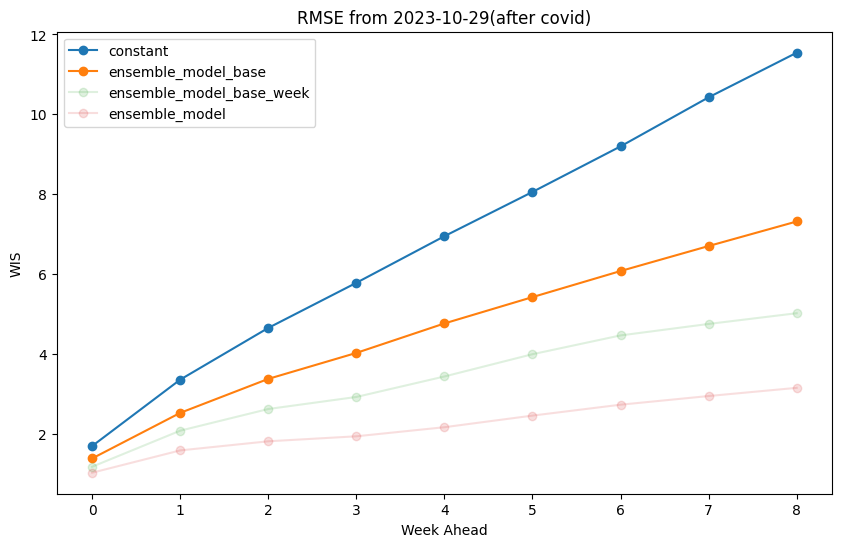

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import numpy  as np
# 读取所有模型的预测结果
model_list = [] #'Nbeats','Nbeats_base' --- IGNORE ---
models = ['constant','ensemble_model_base','ensemble_model_base_week','ensemble_model'] #'AWAE','AWBE' GRU_res_teacher,'ensemble_model_ol','ensemble_model_no_ol'
for model in model_list:
    models.append(f'{model}')

original_method_res = []
pred_steps = 9

def calculate_accuracy_with_tolerance(true_values, pred_values, tolerance=0.25):
    lower_bound = true_values * (1 - tolerance)
    upper_bound = true_values * (1 + tolerance)
    correct = (pred_values >= lower_bound) & (pred_values <= upper_bound)
    accuracy = np.mean(correct)
    return accuracy

mode = 'base_week'
mode2 = 'base_week' # --- IGNORE ---
seed = 42
for model in models:
    # 构建文件路径
    if model == 'constant':
        path = '../res/forc_baseline.csv'
    elif model == 'ensemble_model':
        path = f'../res/ensemble_model_with_intervals.csv'
    elif model == 'ensemble_model_base_week':
        path = f'../res/ensemble_model_with_intervals_base_week.csv'
    elif model == 'ensemble_model_base':
        path = f'../res/ensemble_model_with_intervals_base.csv'
    elif model == 'avg':
        path = f'../res/ensemble_model.csv'
    elif model =='gru':
        path =f'../res/{model}/{model}_{mode}_42test.csv'
    elif model =='gru_base':
        path =f'../res/gru/gru_{mode2}_42test.csv'
    elif model =='tcn_base':
        path =f'../res/tcn/tcn_{mode2}_42test.csv'
    elif model =='tcn':
        path =f'../res/{model}/{model}_{mode}_42test.csv'
    elif model =='Nbeats':
        path =f'../res/{model}/{model}_{mode}_42test.csv'
    elif model =='Nbeats_base':
        path =f'../res/Nbeats/Nbeats_{mode2}_42test.csv'
    elif model =='itransformer':
        path =f'../res/{model}/{model}_{mode}_42test.csv'
    elif model =='itransformer_base':
        path =f'../res/itransformer/itransformer_{mode2}_42test.csv'
    print(path)



    # 读取数据并过滤日期
    res = pd.read_csv(path)

    res['date'] = pd.to_datetime(res['date'])
    if 'mode' in res.columns:
        res = res[(res['mode']=='train')|(res['mode']=='train_seed42')]
    res['date_origin'] = res['date'] - (res['week_ahead'])*timedelta(days=7)
    # Find date_origins where true < 1
    invalid_dates = res.groupby('date').filter(lambda x: (x['true'] <= 1).any())['date'].unique()
    
    # Filter out those date_origins
    res = res[~res['date_origin'].isin(invalid_dates)]
    res = res[(res['date_origin'] >= '2023-10-01')]
    # res = res[(res['date_origin'] < '2024-10-01')]


    res = res.dropna()

    print(f'------------{model}----------------')
    # 计算每个预测周期的RMSE
    model_rmse = []
    for i in range(pred_steps):
        t = res[res['week_ahead']==i]
        wis = t.apply(calculate_wis, axis=1)
        median_ae = median_absolute_error(t['true'], t['point'])
        wis_mean = np.mean(wis)
        rmse = np.sqrt(mean_squared_error(t['true'], t['point']))
        mae = mean_absolute_error(t['true'], t['point'])
        error_std = np.std(t['true']-t['point'])
        mape = mean_absolute_percentage_error(t['true'], t['point'])
        cov_95 = calculate_coverate(t,rate='95')
        accu = calculate_accuracy_with_tolerance(t['true'], t['point'],tolerance=0.50)
        smape = symmetric_mean_absolute_percentage_error(t['true'], t['point'])
        # if model == 'ensemble_model':
        print('RMSE for step %d: %f' % (i, wis_mean))
        model_rmse.append(wis_mean)
    original_method_res.append(model_rmse)
a = np.mean(original_method_res[0])
b = np.mean(original_method_res[1])

print(a,b,(a-b)/a)

# 绘图
weeks = range(pred_steps)
plt.figure(figsize=(10, 6))

labels =   models
alphas = [1, 1, 0.15,0.15, 0.15,0.15,1,0.15,1,0.15]

for res, label, alpha in zip(original_method_res, labels, alphas):
    plt.plot(weeks, res, marker='o', label=label, alpha=alpha)

plt.xlabel('Week Ahead')
plt.ylabel('WIS')
plt.title('RMSE from 2023-10-29(after covid)')
plt.legend()
plt.show()


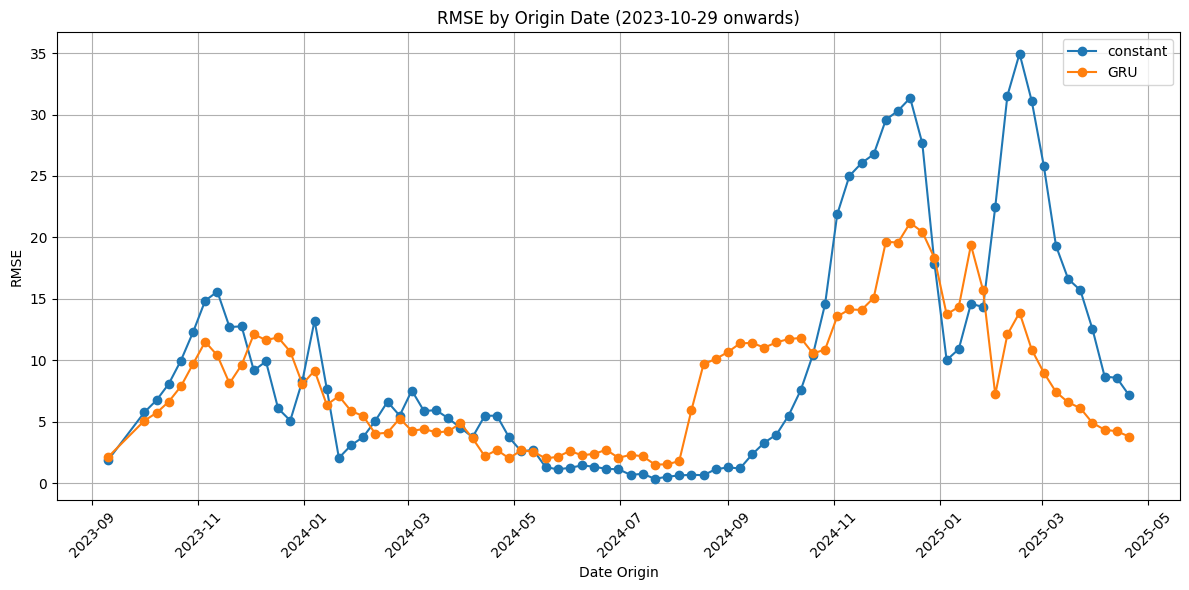

In [13]:
# 读取所有模型的预测结果
models = [ 'constant','GRU']  # 'AWAE','AWBE'
original_method_res = []
pred_steps = 8

plt.figure(figsize=(12, 6))

for model in models:
    # 构建文件路径（保持你的原始路径逻辑）
    if model in ['XGB', 'ARIMA']:
        path = f'../Results/Interval_ydiff_pred/interval_{model}_rolling_test8.csv'
    elif model == 'TSTPlus_v3':
        path = f'../Results/Interval_ydiff_pred/interval_TSTPlus_v3_nontuning_rolling_test8.csv'
    elif model in ['AWAE','AWBE']:
        path = f'../Results/Interval_ydiff_pred/interval_{model}_test8.csv'
    elif model =='GRU_base':
        path = '../../GRU/GRU_predictions_04_23.csv'
    elif model =='GRU_holiday':
        path = '../res/GRU_627.csv'
    elif model == 'constant':
        path = '../res/forc_baseline.csv'
    elif model == 'GRU':
        path = '../res/gru/gru_base_week_holi_pf_42test.csv'
    elif model =='tcn':
        path ='../res/tcn_pf_ol.csv'
    else:
        path = f'../Results/Interval_ydiff_pred/interval_{model}_nontuning_rolling_v2_test8.csv'
    
    # 读取数据
    res = pd.read_csv(path)
    res['date'] = pd.to_datetime(res['date'])
    res['date_origin'] = res['date'] - res['week_ahead'] * timedelta(days=7)
    res = res[(res['date_origin'] > '2023-08-29')]
    invalid_dates = res.groupby('date').filter(lambda x: (x['true'] <= 1).any())['date'].unique()
    # Filter out those date_origins
    res = res[~res['date_origin'].isin(invalid_dates)]
    # res = res[~((res['date_origin'] > '2024-09-01')&(res['date_origin'] < '2024-11-01'))]
    res = res.dropna()
    
    # 按date_origin分组计算RMSE
    rmse_by_date = res.groupby('date_origin').apply(
        lambda x: np.sqrt(mean_squared_error(x['true'], x['point']))
    ).reset_index(name='RMSE')
    
    # 绘制曲线
    plt.plot(rmse_by_date['date_origin'], rmse_by_date['RMSE'], 
             marker='o', linestyle='-', label=model)

plt.xlabel('Date Origin')
plt.ylabel('RMSE')
plt.title('RMSE by Origin Date (2023-10-29 onwards)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## test


FileNotFoundError: [Errno 2] No such file or directory: 'gru_base_week_holi_pf_42test.csv'

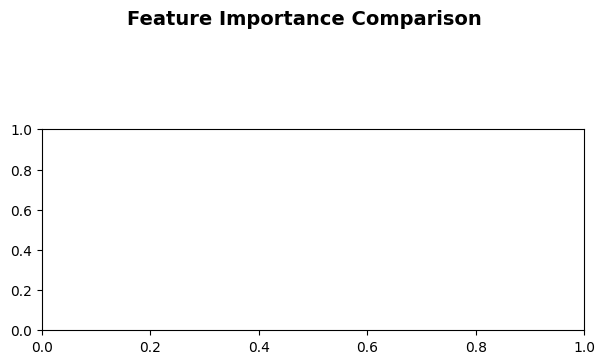

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 定义模型列表
models = ['gru', 'tcn', 'itransformer', 'Nbeats']
pred_steps = 9
display_cols = ['ILI+', 'I', 'beta', 'holiday', 'flu_weekid']
data_cols = [f'feature{i}' for i in range(5)]

# 创建图形（宽度保持较窄）
plt.figure(figsize=(7, 12))
plt.suptitle('Feature Importance Comparison',
             fontsize=14, fontweight='bold', y=0.98)

# 为每个模型创建heatmap
for i, model in enumerate(models):
    ax = plt.subplot(4, 1, i+1)

    # 数据处理部分（保持不变）
    res = pd.read_csv(f'{model}_base_week_holi_pf_42test.csv')
    res = res[res['mode']!='train'].dropna()
    res['date'] = pd.to_datetime(res['date'])
    res['date_origin'] = res['date'] - res['week_ahead']*timedelta(days=7)
    res = res[~res['date_origin'].isin(
        res.groupby('date').filter(lambda x: (x['true'] <= 1).any())['date'].unique()
    )]
    res = res[res['date_origin'] > '2023-08-06']

    # 计算RMSE
    final_rmse = {}
    for j, col in enumerate(data_cols):
        final_rmse[col] = [
            mean_absolute_error(
                res[(res['week_ahead']==k) & (res['mode']==col)]['true'],
                res[(res['week_ahead']==k) & (res['mode']==col)]['point']
            ) for k in range(pred_steps)
        ]

    # 计算base模型
    res_base = pd.read_csv(f'../res/{model}/{model}_base_week_holi_pf_42test.csv')
    res_base = res_base[res_base['mode']=='train'].dropna()
    res_base['date'] = pd.to_datetime(res_base['date'])
    res_base['date_origin'] = res_base['date'] - res_base['week_ahead']*timedelta(days=7)
    res_base = res_base[res_base['date_origin'] > '2023-08-06']

    final_rmse['base'] = [
        mean_absolute_error(
            res_base[res_base['week_ahead']==k]['true'],
            res_base[res_base['week_ahead']==k]['point']
        ) for k in range(pred_steps)
    ]

    # 计算重要性差异
    importance_res = pd.DataFrame({
        display_cols[data_cols.index(col)]: np.array(final_rmse[col]) - np.array(final_rmse['base'])
        for col in data_cols
    })
    colors = [
        (1.0, 1.0, 1.0, 1.0),   # 纯白
        (0.8, 0.1, 0.1, 1.0)    # 深红
    ]
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    # 使用coolwarm colormap绘制热力图
    sns.heatmap(
        importance_res.T,
        annot=False,
        fmt='.2f',
        cbar=False,
        ax=ax,
        square=False,
        cmap=cmap  # 使用coolwarm colormap
    )

    # 调整标签和标题
    ax.set_title(f'{model.upper()}', fontweight='bold', loc='left', pad=5, fontsize=11)
    ax.set_ylabel('')  # 移除y轴标签以节省空间
    ax.tick_params(axis='y', labelsize=9, rotation=0)

    # 仅最后一个子图显示x轴标签
    if i == len(models) - 1:
        ax.set_xlabel('Time Step', fontsize=10)
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])

# 添加共享的colorbar（使用相同的coolwarm colormap）
cbar_ax = plt.gcf().add_axes([0.85, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
    vmin=min(importance_res.min()),
    vmax=max(importance_res.max())
))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('RMSE Diff', fontsize=10)

# 调整子图间距
plt.subplots_adjust(
    top=0.93,
    bottom=0.07,
    left=0.15,
    right=0.83,
    hspace=0.25
)

# 保存和显示
plt.savefig('heatmap_comparison_coolwarm.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
model = ['gru','tcn','itransformer','Nbeats']
res = pd.read_csv(f'../res/{model}/{model}_base_week_holi_pf_42test2025.csv')
res = res[res['mode']!='train']
res['date'] = pd.to_datetime(res['date'])
res['date_origin'] = res['date'] - res['week_ahead']*timedelta(days=7)
# Find date_origins where true < 1
invalid_dates = res.groupby('date').filter(lambda x: (x['true'] <= 1).any())['date'].unique()
# Filter out those date_origins
res = res[~res['date_origin'].isin(invalid_dates)]
res = res[(res['date_origin'] > '2023-08-06')]
res = res.dropna()
pred_steps = 9

final_rmse = {}
# 计算每个预测周期的RMSE
cols = ['ILI+','I','beta','decay_distance','flu_weekid']
for i in range(5):
    info = cols[i]
    model_rmse = []
    for k in range(pred_steps):
        t = res[res['week_ahead']==k]
        t = t[t['mode'] ==info]
        rmse = np.sqrt(mean_squared_error(t['true'], t['point']))
        model_rmse.append(rmse)
    final_rmse[info] = model_rmse

final_rmse = pd.DataFrame(final_rmse)

res = pd.read_csv(f'../res/{model}/{model}_base_week_holi_pf_42test2025.csv')
res['date'] = pd.to_datetime(res['date'])
res = res[res['mode']=='train']
res['date_origin'] = res['date'] - res['week_ahead']*timedelta(days=7)
# Find date_origins where true < 1
invalid_dates = res.groupby('date').filter(lambda x: (x['true'] <= 1).any())['date'].unique()
# Filter out those date_origins
res = res[~res['date_origin'].isin(invalid_dates)]
res = res[(res['date_origin'] > '2023-08-06')]
res = res.dropna()

model_rmse = []
info = 'base'
for k in range(pred_steps):
    t = res[res['week_ahead']==k]
    rmse = np.sqrt(mean_squared_error(t['true'], t['point']))
    model_rmse.append(rmse)
final_rmse[info] = model_rmse

importance_res = {}
for s in final_rmse.columns:
    if s != 'base':
        t = final_rmse[s]
        base = final_rmse['base']
        importance = t-base
        importance_res[s] = importance

importance_res = pd.DataFrame(importance_res)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


importance_res.columns = cols
colors = [
    (1.0, 1.0, 1.0, 1.0),   # 纯白
    (0.8, 0.1, 0.1, 1.0)    # 深红
]
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# 设置热力图
plt.figure(figsize=(10, 8))  # 设置图形大小
sns.heatmap(importance_res.T, annot=False, fmt='.3f', cmap=cmap, cbar_kws={'label': 'RMSE Difference'})
plt.title('Feature Importance: RMSE Difference per Time Step')
plt.xlabel('Time Step')
plt.ylabel('Feature')
plt.yticks(rotation=0)  # y 轴标签横向显示
plt.tight_layout()
plt.savefig(f'heatmap_matrix_forecast_week({model}).pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: "../res/['gru', 'tcn', 'itransformer', 'Nbeats']/['gru', 'tcn', 'itransformer', 'Nbeats']_base_week_holi_pf_42test2025.csv"

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib.colors import LinearSegmentedColormap
# def plot_ip(importance_res,i):
#     # t = importance_res.iloc[i:i+1,:]
#     # t = importance_res.mean(axis=0)
#     i = 7
#     t = importance_res.iloc[i:i+1,:]
#     matrix = np.zeros((7,14))
#
#     for s in importance_res.columns:
#         if s=='base':
#             continue
#         num_part = s.split('feature')[1]
#         # 步骤2：拆分出 i 和 j 的部分
#         a = num_part.split('_time_lag')[0] # feature
#         j = num_part.split('_time_lag')[1]
#         a = int(a)
#         j = 13-int(j) #time lag
#         matrix[a,j] = t[s]
#
#     matrix_norm = (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))
#     rows = ['ILI+','ILI_growth_rate','I','beta','beta_gr']
#     matrix_norm = matrix_norm[:5,:]
#     cols = [f'week_ahead_{i}' for i in range(14)]
#     colors = [
#     (1.0, 1.0, 1.0, 1.0),   # 纯白 (RGB 100%红/绿/蓝，alpha=1)
#     (0.8, 0.1, 0.1, 1.0)    # 深红 (RGB 80%红 + 10%绿/蓝，alpha=1)
# ]
#     cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
#
#     matrix_df = pd.DataFrame(matrix_norm, index=rows, columns=cols)
#
#     # 绘制热力图
#     plt.figure(figsize=(10, 6))  # 设置图形大小
#     sns.heatmap(
#         matrix_df,
#         annot=False,  # 显示矩阵值
#         fmt='.2f',   # 保留两位小数
#         cmap=cmap,   # 使用自定义颜色映射
#         cbar_kws={'label': 'Importance'},  # 颜色条标签
#         vmin=0,      # 值范围最小值
#         vmax=1       # 值范围最大值
#     )
#     plt.title(f'Feature Importance')
#     plt.xlabel('Weeks Ahead')
#     plt.ylabel('Features')
#     plt.yticks(rotation=0)  # y 轴标签横向显示
#     plt.xticks(rotation=45)  # y 轴标签横向显示
#     plt.tight_layout()  # 调整布局以避免标签被裁剪
#     plt.savefig(f'heatmap_matrix_forecast_week(mean).pdf', format='pdf', dpi=300, bbox_inches='tight')
#     plt.close()  # 关闭图形以释放内存
#
# plot_ip(importance_res,i)

In [ ]:
from data_util import *
df = get_data()
df.to_csv('../res/flu_data_all_us.csv', index=False)  # index=False 表示不保存行索引